In [2]:
from IPython.display import Image

# <br><br><span style="color:rebeccapurple">Cross Validation</span>

There are several types of cross validation (CV). In fact, the train/test split is sometimes referred to as the holdout method for CV. 

CV can be used for multiple purposes:
- Check the variability of model parameters
- Tune hyperparameters
- Compare the performance of different models (e.g. logistic regression vs decision tree)
- ...

We will explore a popular type of CV called k-fold CV. The data is split into k disjoint subparts or "folds" and each fold will take turn to be the test set while the rest are used for training.

<div>
<center><img src="kfoldCV.png" width="500"/>
</div>
<center> Source: scikit-learn   
    
In the figure above, we use a 5-fold CV. In iteration 1, we use instances in Fold 1 as the test set, train the model on the remaining instances and obtain a set of parameters. In iteration 2, we use instances in Fold 2 as the test set and obtain another set of parameters from training on the rest of the data. After completing the process, we will have gone through 5 iterations and obtained 5 different sets of parameters.

We will use CV to check the variability of parameters of linear regression models. We won't have time to look into hyperparameter tuning. We will cover model comparison on the 2nd day. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
## Import data
df = pd.read_csv('datasets/fish.csv')
feature_names = df.columns.values[:-1]
# Split the dataset into predictors and response
X = df[feature_names]
Y = np.log(df['weight'])

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Create a pipeline to apply preprocessor
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())]) #(chosen_name, transformer)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

from sklearn.compose import ColumnTransformer
categorical_columns = ['species']
numerical_columns = feature_names[1:]  

# Create preprocessor pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns), #(chosen_name, Pipeline, columns_to_apply_to)
        ('cat', categorical_transformer, categorical_columns)])

from sklearn.linear_model import LinearRegression
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    Y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

In [23]:
labels = feature_names[1:].tolist() + list(cv_model['estimator'][0]['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_columns))

coefs = pd.DataFrame(
    [
        est[-1].coef_ 
        for est in cv_model["estimator"]
    ],
    columns=labels,
)

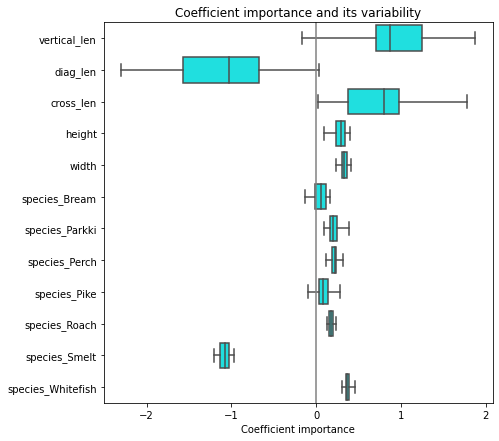

In [24]:
plt.figure(figsize=(9, 7))
# sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

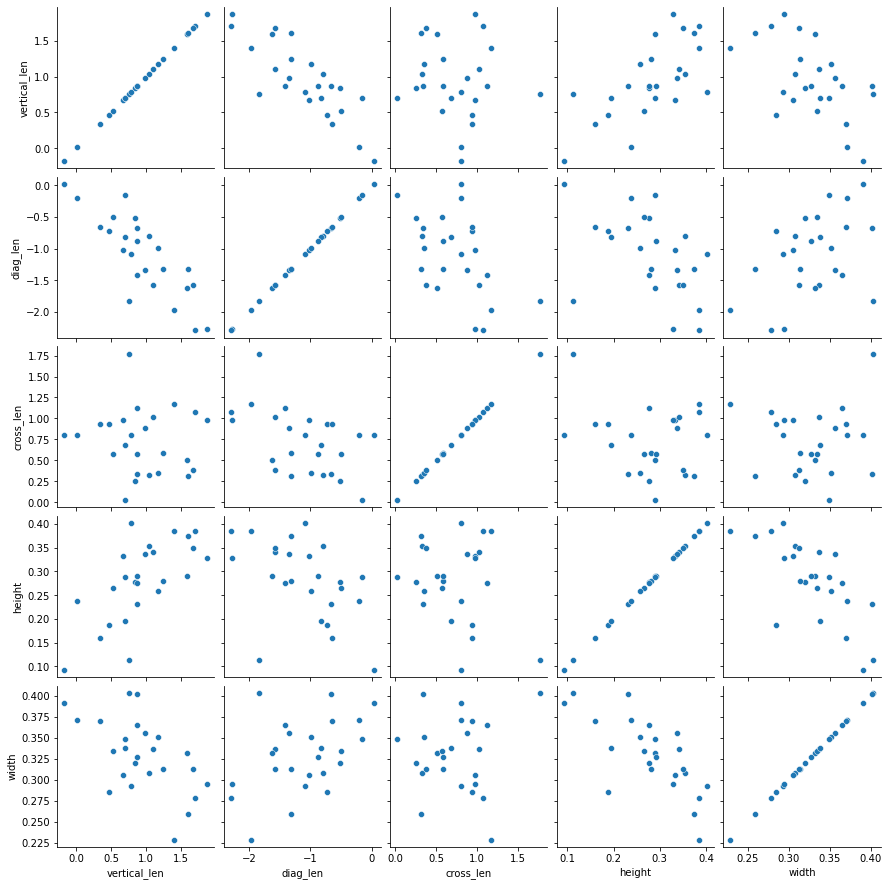

In [25]:
sns.pairplot(coefs[feature_names[1:]], kind="scatter", diag_kind=None)